In [1]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Embedding, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set image dimensions and data path
IMAGE_SIZE = 64
DATA_PATH = r"C:\Users\Marinand\OneDrive - Carrier Corporation\Documents\Grad School\Advanced Machine Learning\Week 4\Assignment 4\UTKFace"

# Load UTKFace dataset
def load_utkface(data_path, img_size):
    images = []
    conditions = []

    for file in os.listdir(data_path):
        if file.endswith(".jpg"):
            parts = file.split("_")
            if len(parts) < 2:
                continue

            try:
                age = int(parts[0])
                gender = int(parts[1])

                img_path = os.path.join(data_path, file)
                img = Image.open(img_path)
                img = img.resize((img_size, img_size))
                img_array = np.array(img)

                if img_array.shape == (img_size, img_size, 3):
                    images.append(img_array)
                    conditions.append([age, gender])
            except Exception as e:
                print(f"Error processing file {file}: {e}")

    images = np.array(images, dtype="float32")
    conditions = np.array(conditions, dtype="float32")

    images = (images / 127.5) - 1.0  # Normalize to [-1, 1]
    conditions[:, 0] /= 100  # Normalize age to [0, 1]

    return images, conditions

images, conditions = load_utkface(DATA_PATH, IMAGE_SIZE)

# One-hot encode gender
ages = conditions[:, 0]
genders = to_categorical(conditions[:, 1], num_classes=2)

conditions_normalized = np.hstack((ages.reshape(-1, 1), genders))

In [3]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate, LeakyReLU

# Set random seed for reproducibility
import numpy as np
import tensorflow as tf

np.random.seed(1000)
tf.random.set_seed(1000)

# Constants
IMAGE_SIZE = 64  # Define IMAGE_SIZE
IMG_ROWS = IMAGE_SIZE
IMG_COLS = IMAGE_SIZE
IMG_CHANNELS = 3  # RGB images
LATENT_DIM = 100
EPOCHS = 1000
BATCH_SIZE = 64
SAVE_INTERVAL = 1000

# Build the generator model
def build_generator(latent_dim):
    noise_input = Input(shape=(latent_dim,))
    label_input = Input(shape=(2,))  # Age and gender combined as a 2-element vector
    
    # Combine latent vector and label input
    x = Concatenate()([noise_input, label_input])
    
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(np.prod((64, 64, 3)), activation='tanh')(x)  # Output size is 64x64x3
    img_output = Reshape((64, 64, 3))(x)
    
    model = Model([noise_input, label_input], img_output)
    return model

# Build the discriminator model
def build_discriminator():
    img = Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))
    label = Input(shape=(2,))  # Age and gender combined as a 2-element vector

    label_embedding = Dense(np.prod((IMG_ROWS, IMG_COLS, IMG_CHANNELS)))(label)
    label_embedding = Reshape((IMG_ROWS, IMG_COLS, IMG_CHANNELS))(label_embedding)

    concatenated = Concatenate(axis=-1)([img, label_embedding])

    x = Flatten()(concatenated)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    validity = Dense(1, activation='sigmoid')(x)

    model = Model([img, label], validity)
    return model

# Build the cGAN model
def build_cgan(generator, discriminator):
    discriminator.trainable = False
    noise = Input(shape=(LATENT_DIM,))
    label = Input(shape=(2,))  # Age and gender combined as a 2-element vector
    img = generator([noise, label])  # Generate image from latent and label
    validity = discriminator([img, label])  # Evaluate validity with discriminator
    model = Model([noise, label], validity)
    return model

# Compile models
optimizer = Adam(0.0001, 0.5)

generator = build_generator(LATENT_DIM)
discriminator = build_discriminator()
cgan = build_cgan(generator, discriminator)

discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
cgan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Train the cGAN model
def train(generator, discriminator, cgan, epochs, batch_size, save_interval):
    half_batch = batch_size // 2
    X_train = images
    labels = conditions_normalized

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        label_real = labels[idx, :2]

        noise = np.random.normal(0, 1, (half_batch, LATENT_DIM))
        fake_labels = np.random.randint(0, 2, (half_batch, 2))

        # Generate fake images and labels
        gen_imgs = generator.predict([noise, fake_labels])

        real_preds = discriminator.predict([imgs, label_real])
        fake_preds = discriminator.predict([gen_imgs, fake_labels])

        # Compute the discriminator loss
        d_loss_real = tf.keras.losses.BinaryCrossentropy(from_logits=True)(np.ones_like(real_preds), real_preds)
        d_loss_fake = tf.keras.losses.BinaryCrossentropy(from_logits=True)(np.zeros_like(fake_preds), fake_preds)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
        fake_labels = np.random.randint(0, 2, (batch_size, 2))
        valid_labels = np.ones((batch_size, 1))

        g_loss = cgan.train_on_batch([noise, fake_labels], valid_labels)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss}] [G loss: {g_loss}]")
            save_images(epoch)

# Save generated images at intervals
def save_images(epoch):
    # Create the directory if it doesn't exist
    if not os.path.exists("images"):
        os.makedirs("images")

    noise = np.random.normal(0, 1, (10, LATENT_DIM))
    labels = np.hstack([np.linspace(0, 1, 10).reshape(-1, 1), np.zeros((10, 1))])  # Age and gender for labels
    gen_imgs = generator.predict([noise, labels])
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(1, 10, figsize=(10, 1))
    for i in range(10):
        axs[i].imshow(gen_imgs[i])
        axs[i].axis('off')
    plt.savefig(f"images/utkface_{epoch}.png")
    plt.close()

# Now call the train function
train(generator, discriminator, cgan, EPOCHS, BATCH_SIZE, SAVE_INTERVAL)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


c:\Users\Marinand\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_26', 'keras_tensor_27']. Received: the structure of inputs=('*', '*')
  warnings.warn(
c:\Users\Marinand\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_35', 'keras_tensor_36']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
0 [D loss: 0.7270137071609497] [G loss: [array(0.6890475, dtype=float32), array(0.671875, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def generate_image_from_input(age, gender, generator, latent_dim):
    # Normalize the input age to be in the range [0, 1]
    age_normalized = age / 100.0  # Assuming age is in range [0, 100]

    # Create a label vector with the given age and gender
    label_input = np.array([[age_normalized, gender]])  # gender should be 0 (female) or 1 (male)

    # Generate random noise for the latent vector
    noise_input = np.random.normal(0, 1, (1, latent_dim))  # LATENT_DIM should be defined

    # Use the generator to create a synthetic image from the noise and label input
    generated_image = generator.predict([noise_input, label_input])

    # Ensure the generated image is in the range [0, 1] if the generator outputs in [-1, 1]
    generated_image = 0.5 * generated_image + 0.5  # Rescale back to [0, 1]

    # Check if the generated image is a 3D array (e.g., for RGB images)
    if generated_image.shape[-1] == 1:
        # Convert grayscale to RGB for display
        generated_image = np.repeat(generated_image, 3, axis=-1)

    # Plot the generated image
    plt.imshow(generated_image[0])  # Assuming the first image in the batch
    plt.axis('off')
    plt.show()

    return generated_image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


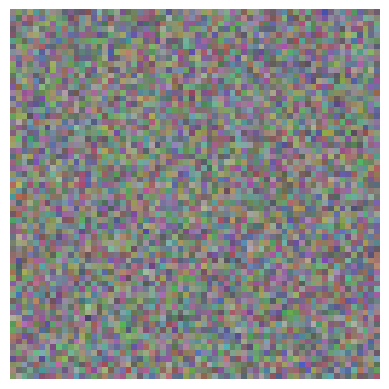

In [14]:
generated_image = generate_image_from_input(100, 1, generator, LATENT_DIM)  # 100 year old male

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


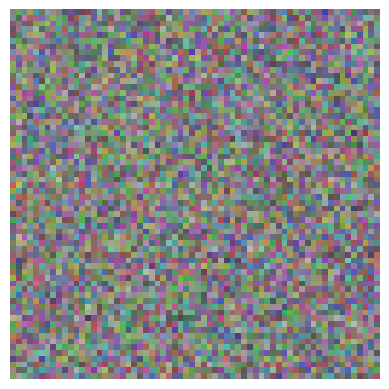

In [15]:
generated_image = generate_image_from_input(50, 1, generator, LATENT_DIM)  # 50 year old male

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


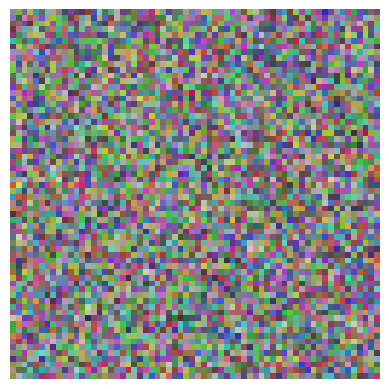

In [16]:
generated_image = generate_image_from_input(1, 1, generator, LATENT_DIM)  # 1 year old male

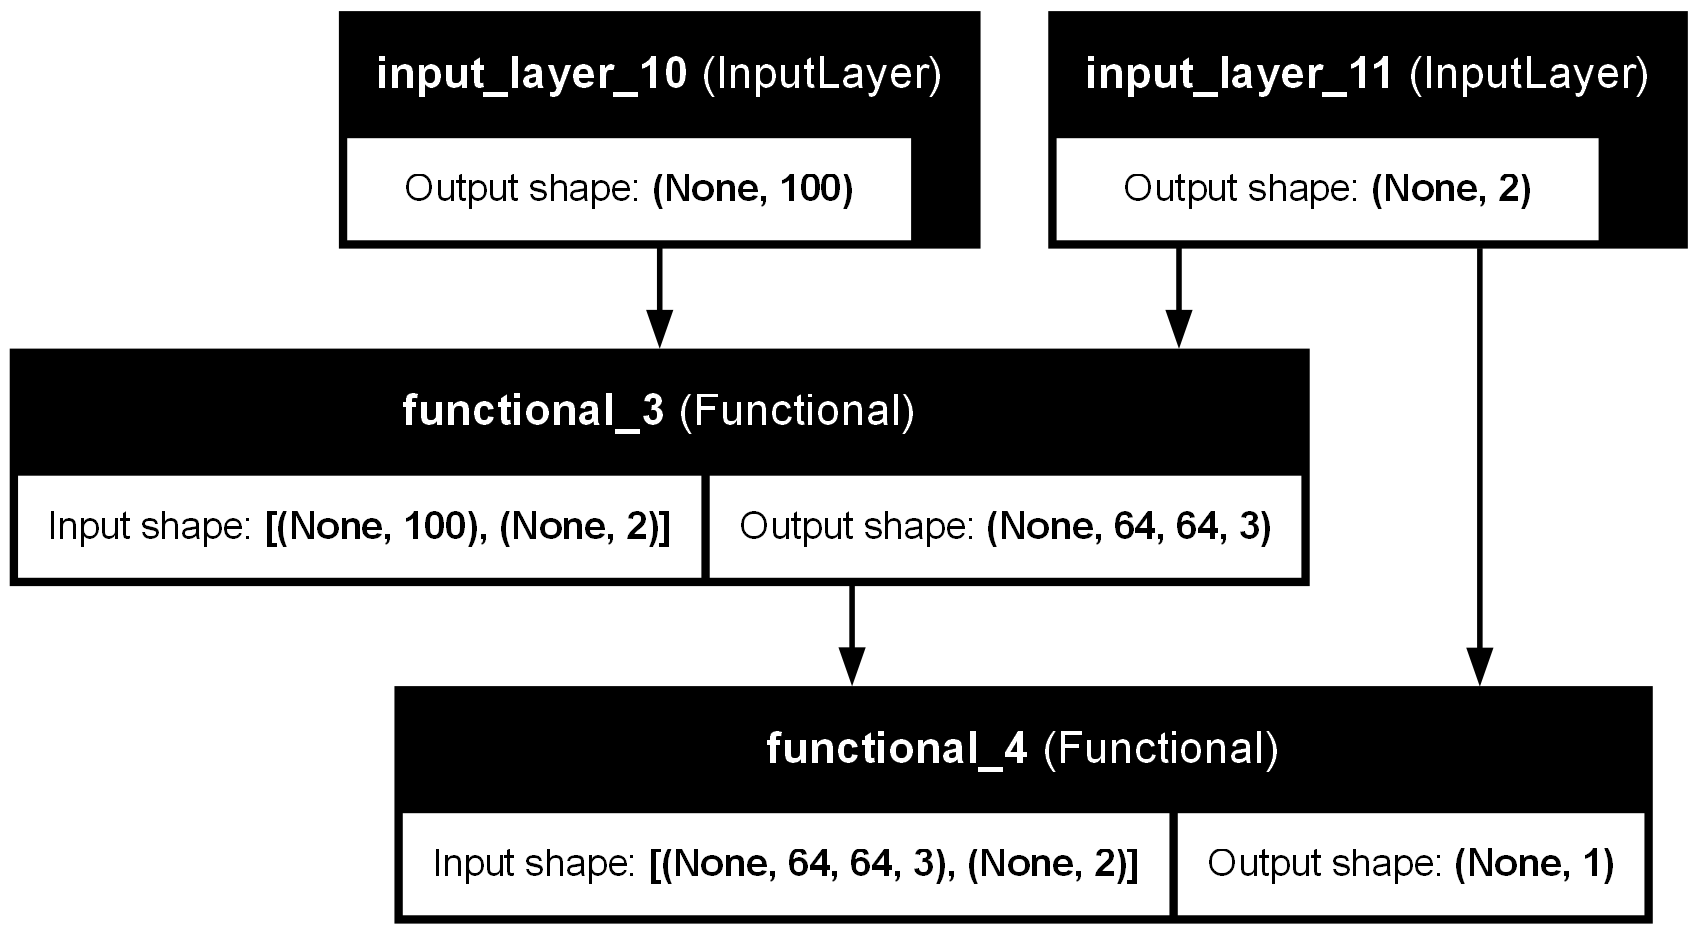

In [17]:
from tensorflow.keras.utils import plot_model

# Plot the Generator Model
plot_model(generator, to_file='generator_model.png', show_shapes=True, show_layer_names=True)

# Plot the Discriminator Model
plot_model(discriminator, to_file='discriminator_model.png', show_shapes=True, show_layer_names=True)

# Plot the cGAN Model
plot_model(cgan, to_file='cgan_model.png', show_shapes=True, show_layer_names=True)